# Google Earth Engine

## Datasets catalog

Link: https://developers.google.com/earth-engine/datasets

Browse the various datasets available. Gives details of the different satellite imagery available, how the data is preprocessed, frequency, resolution etc. Also gives Javascipt code snippets for each top copy into the UI.

## Interactive Javascript UI

Link: https://code.earthengine.google.com/ 

Can use to draw bounding boxes to get coordinates for the satellite data you want.


## Python API

Run the following to authenticate. Need to create a project on GCP first and enable the _Google Earth Engine API_.

In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AdQt8qjChdHzLUadBEFXWVI7Dns6NudO-obvhlXeYYtybP5OvGHodoi0v8w



Successfully saved authorization token.


In [2]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')


In [3]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)


In [4]:
# Define the urban location of interest as a point roughly near the snow basins.
lat = 39.988555
lon = -120.897120
poi = ee.Geometry.Point(lon, lat)

In [5]:
scale = 1000  # scale in meters

# Print the elevation near the point.
elv_point = elv.sample(poi, scale).first().get('elevation').getInfo()
print('Ground elevation at point:', elv_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_point = lst.mean().sample(poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at point:', round(lst_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_point = lc.first().sample(poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_point)


Ground elevation at point: 1250 m
Average daytime LST at point: 21.26 °C
Land cover value at urban point is: 8


In [6]:
# Get the data for the pixel intersecting the point.
lst_poi = lst.getRegion(poi, scale).getInfo()

# Preview the result.
lst_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01', -120.89976251322581, 39.9885048725805, 1483228800000, None, 2],
 ['2017_01_02', -120.89976251322581, 39.9885048725805, 1483315200000, None, 2],
 ['2017_01_03', -120.89976251322581, 39.9885048725805, 1483401600000, None, 2],
 ['2017_01_04', -120.89976251322581, 39.9885048725805, 1483488000000, None, 2]]

In [7]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time', 'datetime',  *list_of_bands]]

    return df


In [8]:
lst_df = ee_array_to_df(lst_poi, ['LST_Day_1km'])


def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius


# Apply the function to get temperature in celsius.
lst_df['LST_Day_1km'] = lst_df['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df.head()

,time,datetime,LST_Day_1km
4,1483574400000,2017-01-05,-1.13
12,1484265600000,2017-01-13,2.51
15,1484524800000,2017-01-16,2.07
22,1485129600000,2017-01-23,-2.47
23,1485216000000,2017-01-24,0.35


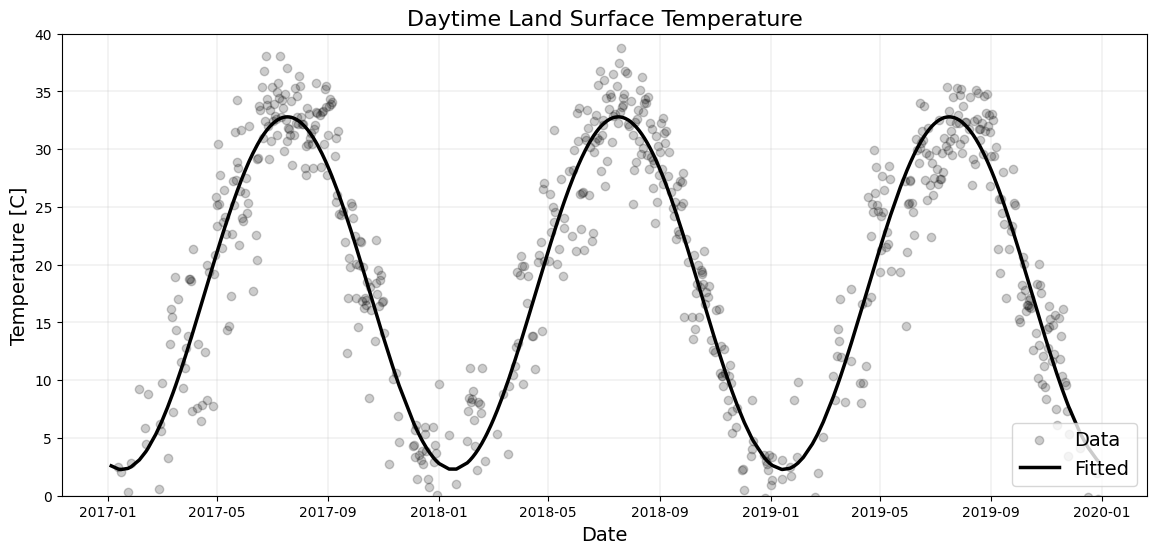

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data = np.asanyarray(lst_df['time'].apply(float))  # urban

## Secondly, extract y values (LST) from the dfs.
y_data = np.asanyarray(lst_df['LST_Day_1km'].apply(float))  # urban

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data, y_data, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df['datetime'], lst_df['LST_Day_1km'],
           c='black', alpha=0.2, label='Data')

# Add fitting curves.
ax.plot(lst_df['datetime'],
        fit_func(x_data, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Fitted', color='black', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()


In [10]:
# Define a region of interest with a buffer zone of 100 km.
roi = poi.buffer(100_000)

In [11]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)


In [12]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b95a20d388f7943505b6ca1dcc3cb57-baa8923eaa73f32b0ed6e748cfd51f8d:getPixels


In [13]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [14]:
url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)


In [15]:
# Save geotiff to GDrive:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_snowbasins',
                                     scale=30,
                                     region=roi,
                                     fileNamePrefix='my_export_snowbasins',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [16]:
task.status()

{'state': 'READY',
 'description': 'elevation_near_snowbasins',
 'creation_timestamp_ms': 1662500409703,
 'update_timestamp_ms': 1662500409703,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'JP6X43QEAH7KHJ6US5FVWSAR',
 'name': 'projects/earthengine-legacy/operations/JP6X43QEAH7KHJ6US5FVWSAR'}

In [17]:
import folium

# Define the center of our map.
my_map = folium.Map(location=[lat, lon], zoom_start=7)
my_map

In [18]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


In [19]:
# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)


In [20]:
# my_map.save('my_lc_interactive_map.html')

In [21]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map


In [34]:
# Import the MODIS data used in the model.
mds = ee.ImageCollection("MODIS/006/MOD10A1")

# Select a specific band and dates for NDSI_Snow_Cover.
md_img = mds.select('NDSI_Snow_Cover').filterDate(i_date).first()

# Set visualization parameters for land cover.
mds_vis_params = {
    'min': 0,'max': 100,
    "palette": ['d6f5f5', '000099']
}

# Create a map.
my_map = folium.Map(location=[lat, lon], zoom_start=8)

# Add the land cover to the map object.
my_map.add_ee_layer(md_img, mds_vis_params, 'NDSI_Snow_Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)


In [36]:
# Set visualization parameters for Modis band 1. (blue)
m1_vis_params = {
    'min': 0,'max': 100,
    'palette': ['e6e6ff', "000033"]}

# Set visualization parameters for Modis band 2. (red)
m2_vis_params = {
    'min': 0,'max': 100,
    'palette': ['ffebe6', '661400']}

# Set visualization parameters for Modis band 3. (green)
m3_vis_params = {
    'min': 0,'max': 100,
    'palette': ['ccffcc', '004d00']}

# Arrange layers inside a list.
m1_img = mds.select('NDSI_Snow_Cover').filterDate(i_date).first()
m2_img = mds.select('Snow_Albedo_Daily_Tile').filterDate(i_date).first()
m3_img = mds.select('NDSI').filterDate(i_date).first().divide(100)

ee_tiles = [m1_img, m2_img, m3_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [m1_vis_params, m2_vis_params, m3_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['NDSI_Snow_Cover', 'Snow_Albedo_Daily_Tile', 'NDSI']

# Create a new map.
my_map = folium.Map(location=[lat, lon], zoom_start=8)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map


## scratch below

In [22]:
raise

RuntimeError: No active exception to reraise

In [ ]:

import datetime
from typing import *

import shapely


def get_ee_img(coords: List[float], satellite_name: str, 
               date_to: datetime.datetime, date_from: datetime.datetime = None, 
               date_delta: datetime.timedelta = datetime.timedelta(days=7),
               buffer_percent: float = 0.0):
    """Get ee.ImageCollection specifications for satellite data."""
    
    # Parse the date parameters:
    if isinstance(date_to, str):
        date_to = datetime.datetime.fromisoformat(date_to)
    if date_from is None:
        date_from = date_to - date_delta
    elif isinstance(date_from, str):
        date_from = datetime.datetime.fromisoformat(date_from)
    date_to += datetime.timedelta(days=1)

    # Filter the geometry:
    polygon = shapely.geometry.Polygon(coords)
    area = ee.Geometry.Polygon(list(
        shapely.affinity.scale(polygon, xfact=(1. + buffer_percent), yfact=(1. + buffer_percent)).exterior.coords
    ))

    # Get the data:
    return ee.ImageCollection(satellite_name).filterDate(date_from, date_to).filterBounds(area)

In [ ]:
coords = [
    [-74.07807407603283,40.54466085231029],
    [-73.64960727915783,40.54466085231029], 
    [-73.64960727915783,40.751487695700874],
    [-74.07807407603283,40.751487695700874],
    [-74.07807407603283,40.54466085231029],
]

ic = get_ee_img(coords, satellite_name="MODIS/006/MCD43A4",
                date_to="2022-08-31", date_from="2022-08-01")

In [ ]:
bands = ("Nadir_Reflectance_Band1", "BRDF_Albedo_Band_Mandatory_Quality_Band1")
img = ic \
    .filter(ee.Filter.notNull(['system:index'])) \
    .select(list(bands)) \
    .sort('system:index', False) \
    .first()
img

In [ ]:
ee.data.getMapId?

In [ ]:
img.getMapId?

In [ ]:
img.getThumbUrl?    url = point.select(rgb).clip(aoi).getThumbURL({'min': 0, 'max': 100, 'region': aoi, 'format': 'jpg'})


In [ ]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)


In [ ]:
   # First I get the image collection from the MODIS data, filter it only to
    # the days in question and select my bands, then sort so the most recent day
    # in the group is at the top
    try:
        point = ee.ImageCollection(f'MODIS/006/{modis}') \
            .filterDate(start_date, end_date) \
            .filterBounds(aoi) \
            .filter(ee.Filter.notNull(['system:index'])) \
            .select(['NDSI_Snow_Cover', 'Snow_Albedo_Daily_Tile', 'NDSI']) \
            .sort('system:index', False) \
            .first() \
            .unmask(0)

    except Exception as e:
        print(e)
        print("Some Error with Image Collection")
        print("Have you logged in to google earth engine?")
        return

    # Get individual band arrays and build them into an RGB image
    SnowCover = point.select('NDSI_Snow_Cover')
    Albedo = point.select('Snow_Albedo_Daily_Tile')
    Raw = point.select('NDSI').divide(100)

    point = point.addBands(SnowCover.rename('SnowCover'))
    point = point.addBands(Albedo.rename('Albedo'))
    point = point.addBands(Raw.rename('Raw'))

    rgb = ['SnowCover', 'Albedo', 'Raw']

    # get URL for image
    url = point.select(rgb).clip(aoi).getThumbURL({'min': 0, 'max': 100, 'region': aoi, 'format': 'jpg'})

    try:
        r = urllib.request.urlopen(url)
        im = Image.open(r)
        return numpy.array(im)

    except Exception as e:
        print(e)

In [ ]:
img = ee.Image("NASA/NASADEM_HGT/001")
print(img.get("title").getInfo())